# Evaluation of text similarity metrics using GLUE tasks

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import evaluate
import transformers

from bert_score import BERTScorer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_dataset
from transformers import logging
logging.set_verbosity_error()


class STSScorer:
    def __init__(self):
        model_name = 'WillHeld/roberta-base-stsb'
        self._sts_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
        self._sts_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name)
        self._sts_model.eval()

    def score(self, sentence1, sentence2):
        sts_tokenizer_output = self._sts_tokenizer(sentence1, sentence2, padding=True, truncation=True, return_tensors="pt")
        sts_model_output = self._sts_model(**sts_tokenizer_output)
        return sts_model_output['logits'].item()/5
    
class SBERTCosine:
    def __init__(self):
        model_name = 'sentence-transformers/all-MiniLM-L6-v2'
        self._sbert_model = SentenceTransformer(model_name)
        self._sbert_model.eval()

    def score(self, sentence1, sentence2):
        embeddings = self._sbert_model.encode([sentence1, sentence2])
        return cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]

bertscorer = BERTScorer(lang="en", rescale_with_baseline=True)
bleu = evaluate.load("bleu")
sts_scorer = STSScorer()
sbertcosine = SBERTCosine()

def fetch_scores(data, feature1, feature2):
    print(len(data))
    scores = []
    count = 0
    for instance in data:
        bert_score = bertscorer.score([instance[feature1]], [instance[feature2]], verbose=False)
        bleu_score = bleu.compute(predictions=[instance[feature1]], references=[instance[feature2]])['bleu']
        stsb_score = sts_scorer.score(instance[feature1], instance[feature2])
        sbert_score = sbertcosine.score(instance[feature1], instance[feature2])
        scores.append({'label': instance['label'], 'bertscore_precision': bert_score[0].item(), 'bertscore_recall': bert_score[1].item(), 'bertscore_f1': bert_score[2].item(), 'bleu': bleu_score, 'sts_score': stsb_score, 'sbertcosine': sbert_score})
        count += 1
        if count % 1000 == 0:
            print(count)
        if count > 100:
            #break
            pass
    return scores

## STS-B

In [8]:
data = load_dataset("stsb_multi_mt", name="en", split="test")
data = data.rename_column("similarity_score", "label")
scores_stsb = pd.DataFrame(fetch_scores(data, 'sentence1', 'sentence2'))

scores_stsb.to_csv('scores/stsb.csv')

Found cached dataset stsb_multi_mt (/home/sherbold/.cache/huggingface/datasets/stsb_multi_mt/en/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


1379
1000


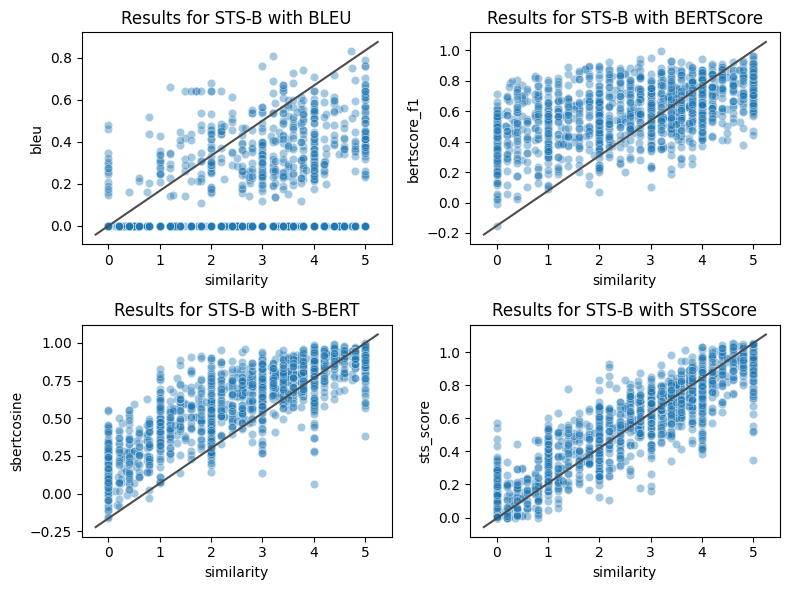

Pearson correlation


bleu            0.337758
bertscore_f1    0.528701
sts_score       0.895954
sbertcosine     0.827406
Name: label, dtype: float64

Spearman correlation


bleu            0.322598
bertscore_f1    0.527128
sts_score       0.889744
sbertcosine     0.820325
Name: label, dtype: float64

In [10]:
scores_stsb = pd.read_csv('scores/stsb.csv')

def draw_diagonal(ax):
    ax.plot(ax.get_xlim(), ax.get_ylim(), c=".3")

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.scatterplot(x="label", y="bleu", data=scores_stsb, alpha=0.4, ax=axes[0,0])
sns.scatterplot(x="label", y="bertscore_f1", data=scores_stsb, alpha=0.4, ax=axes[0,1])
sns.scatterplot(x="label", y="sbertcosine", data=scores_stsb, alpha=0.4, ax=axes[1,0])
sns.scatterplot(x="label", y="sts_score", data=scores_stsb, alpha=0.4, ax=axes[1,1])
draw_diagonal(axes[0,0])
draw_diagonal(axes[0,1])
draw_diagonal(axes[1,0])
draw_diagonal(axes[1,1])
axes[0,0].set_ylabel("Similarity")
axes[0,1].set_ylabel("Similarity")
axes[1,0].set_ylabel("Similarity")
axes[1,1].set_ylabel("Similarity")
axes[0,0].set_xlabel("Label")
axes[0,1].set_xlabel("Label")
axes[1,0].set_xlabel("Label")
axes[1,1].set_xlabel("Label")
axes[0,0].set_title("Results for STS-B with BLEU")
axes[0,1].set_title("Results for STS-B with BERTScore")
axes[1,0].set_title("Results for STS-B with S-BERT")
axes[1,1].set_title("Results for STS-B with STSScore")

fig.tight_layout()
plt.savefig('plots/stsb.pdf', bbox_inches='tight')
plt.show()

print('Pearson correlation')
display(scores_stsb.corr(method='pearson')['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])
print('Spearman correlation')
display(scores_stsb.corr(method='spearman')['label'][['bleu', 'bertscore_f1', 'sts_score', 'sbertcosine']])

## MRPC

In [11]:
data = load_dataset('glue', 'mrpc')['test']
scores_mrpc = pd.DataFrame(fetch_scores(data, 'sentence1', 'sentence2'))
scores_mrpc.to_csv('scores/mrpc.csv')

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 535.79it/s]


1725
1000


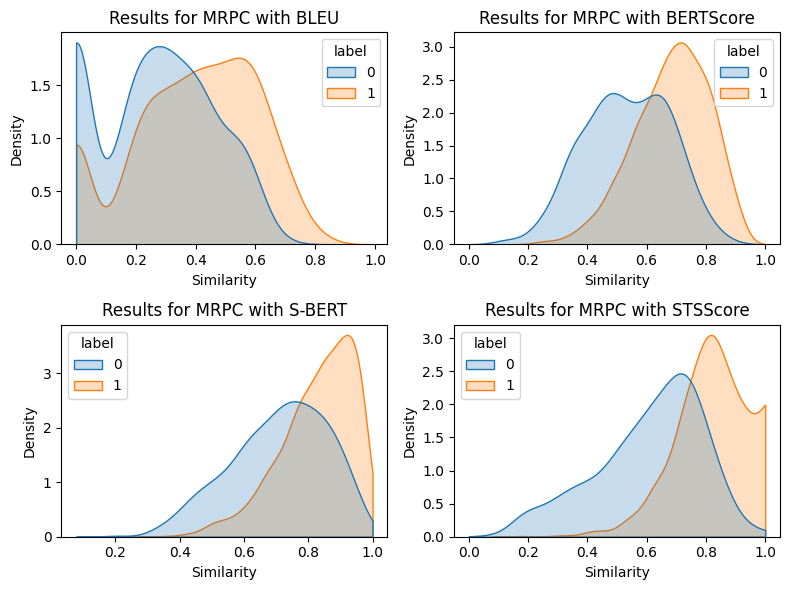

Mean


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,887.468858,0.535354,0.530234,0.532616,0.260324,0.610237,0.709273
1,849.165650,0.684321,0.682521,0.683187,0.392253,0.837354,0.827843


Standard deviation


,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score,sbertcosine
label,,,,,,,
0,505.174105,0.159769,0.164882,0.145341,0.191747,0.180009,0.149024
1,494.234810,0.142888,0.139676,0.125755,0.209861,0.134796,0.115480


In [14]:
scores_mrpc = pd.read_csv('scores/mrpc.csv')
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.kdeplot(scores_mrpc, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,0])
sns.kdeplot(scores_mrpc, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,1])
sns.kdeplot(scores_mrpc, x="sbertcosine", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,0])
sns.kdeplot(scores_mrpc, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,1])

axes[0,0].set_xlabel("Similarity")
axes[0,1].set_xlabel("Similarity")
axes[1,0].set_xlabel("Similarity")
axes[1,1].set_xlabel("Similarity")
axes[0,0].set_title("Results for MRPC with BLEU")
axes[0,1].set_title("Results for MRPC with BERTScore")
axes[1,0].set_title("Results for MRPC with S-BERT")
axes[1,1].set_title("Results for MRPC with STSScore")

sns.move_legend(axes[1,0], "upper left")
sns.move_legend(axes[1,1], "upper left")
fig.tight_layout()
plt.savefig('plots/mrpc.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_mrpc.groupby('label').mean())
print('Standard deviation')
display(scores_mrpc.groupby('label').std())

## QQP

In [27]:
data = load_dataset('glue', 'qqp')['train']
scores_qqp = pd.DataFrame(fetch_scores(data, 'question1', 'question2'))
scores_qqp.to_csv('scores/qqp.csv')

Found cached dataset glue (/home/sherbold/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 367.89it/s]


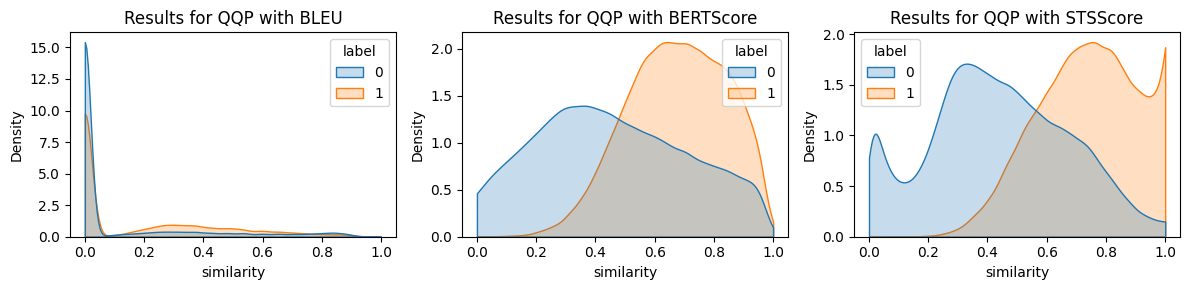

Mean


,Unnamed: 0.1,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,,,
0,182006.746963,182006.746963,0.438191,0.444688,0.441274,0.113036,0.439641
1,181778.637299,181778.637299,0.673945,0.673659,0.673431,0.184540,0.762966


Standard deviation


,Unnamed: 0.1,Unnamed: 0,bertscore_precision,bertscore_recall,bertscore_f1,bleu,sts_score
label,,,,,,,
0,105000.718917,105000.718917,0.275215,0.275584,0.264823,0.232932,0.236197
1,105089.519470,105089.519470,0.180303,0.180175,0.166039,0.249377,0.181817


In [28]:
scores_qqp = pd.read_csv('scores/qqp.csv')
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
sns.kdeplot(scores_qqp, x="bleu", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,0])
sns.kdeplot(scores_qqp, x="bertscore_f1", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[0,1])
sns.kdeplot(scores_qqp, x="sbertcosine", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,0])
sns.kdeplot(scores_qqp, x="sts_score", hue="label", fill=True, common_norm=False, clip=[0,1], ax=axes[1,1])

axes[0,0].set_xlabel("Similarity")
axes[0,1].set_xlabel("Similarity")
axes[1,0].set_xlabel("Similarity")
axes[1,1].set_xlabel("Similarity")
axes[0,0].set_title("Results for QQP with BLEU")
axes[0,1].set_title("Results for QQP with BERTScore")
axes[1,0].set_title("Results for QQP with S-BERT")
axes[1,1].set_title("Results for QQP with STSScore")

sns.move_legend(axes[2], "upper left")
fig.tight_layout()
plt.savefig('plots/qqp.pdf', bbox_inches='tight')
plt.show()
print('Mean')
display(scores_qqp.groupby('label').mean())
print('Standard deviation')
display(scores_qqp.groupby('label').std())